# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,13,80,80,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(80,80)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,13,80,80,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(80,80)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## First Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2025-01-01 16:36:53.983181: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-01 16:36:53.983243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22855 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-01 16:36:59.961051: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.8102 - categorical_accuracy: 0.3616Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-0116_36_52.990735/model-00001-1.81025-0.36161-1.59535-0.28125.h5
21/21 [==============================] - 96s 5s/step - loss: 1.8102 - categorical_accuracy: 0.3616 - val_loss: 1.5953 - val_categorical_accuracy: 0.2812 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3008 - categorical_accuracy: 0.4955
Epoch 00002: saving model to model_init_2025-01-0116_36_52.990735/model-00002-1.30084-0.49554-1.90084-0.24219.h5
21/21 [==============================] - 82s 4s/step - loss: 1.3008 - categorical_accuracy: 0.4955 - val_loss: 1.9008 - val_categorical_accuracy: 0.2422 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1187 - categorical_accuracy: 0.5923
Epoch 00003: saving model to model_init_2025-01-0116_36_52.990735/model-0000

In [13]:
print("Total Params:", model.count_params())

Total Params: 1733509


<Figure size 720x720 with 0 Axes>

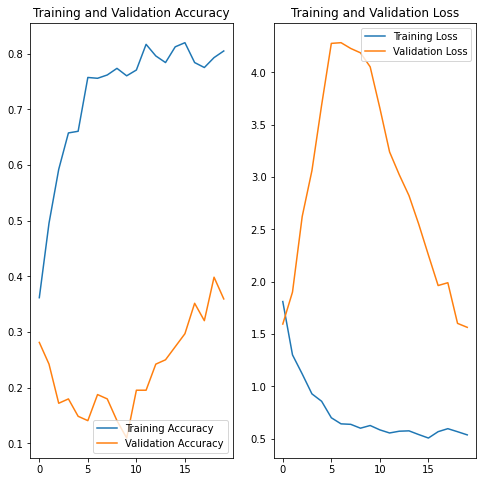

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Second Model
In previous model we saw that validation accuracy is increased compared to the previous model. This concludes no of epochs increased do not help much in improving the model which is overfitting.

Now we will try to implement the CNN + LSTM model and will compare the results with the second model which had highest validation accuracy.


In previous model model is having overall less training and validation accuracy, but we see steady trend in increasing the training and validation accuracy. Adding more epochs can help here to further improve the accuracy.

In [17]:
from keras.layers.recurrent import LSTM

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [18]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_3 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_5 (Batc  (None, 13, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 6, 40, 40, 64)    

In [19]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%new_batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/new_batch_size)
else:
    steps_per_epoch = (num_train_sequences//new_batch_size) + 1

if (num_val_sequences%new_batch_size) == 0:
    validation_steps = int(num_val_sequences/new_batch_size)
else:
    validation_steps = (num_val_sequences//new_batch_size) + 1

In [20]:
num_epochs6=20
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs6, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  datasets/Project_data/train ; batch size = 32
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 2.0143 - categorical_accuracy: 0.2415Source path =  datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-0116_36_52.990735/model-00001-2.01431-0.24148-1.60492-0.21875.h5
11/11 [==============================] - 41s 4s/step - loss: 2.0143 - categorical_accuracy: 0.2415 - val_loss: 1.6049 - val_categorical_accuracy: 0.2188 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.7924 - categorical_accuracy: 0.3182
Epoch 00002: saving model to model_init_2025-01-0116_36_52.990735/model-00002-1.79239-0.31818-1.60002-0.29688.h5
11/11 [==============================] - 35s 4s/step - loss: 1.7924 - categorical_accuracy: 0.3182 - val_loss: 1.6000 - val_categorical_accuracy: 0.2969 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.8072 - categorical_accuracy: 0.2841
Epoc

<Figure size 720x720 with 0 Axes>

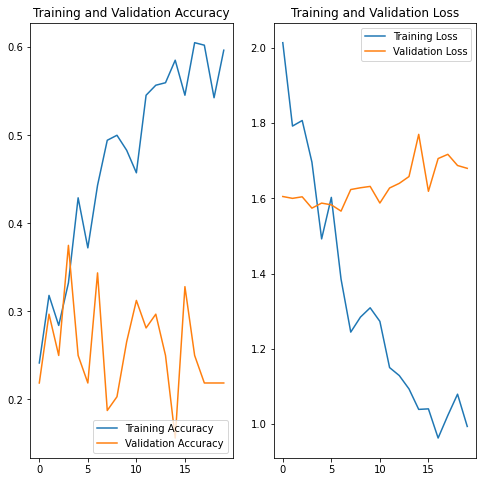

In [21]:
plt.figure(figsize = (10,10))

acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(num_epochs6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model did reach good training as well as validation accuracy. Training Accuracy = 0.96 Validation Accuracy = 0.83